# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In images, there are faces and **keypoints, with coordinates (x, y)**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on.

---

## Load and Visualize Data

The first step in working with any dataset is to become familiar with your data; you'll need to load in the images of faces and their keypoints and visualize them! 

#### Training and Testing Data

This facial keypoints dataset consists of thousands gray images. All of these images are separated into either a training or a test set of data.

* training images are for you to use as you create a model to predict keypoints.
* test images are unknown to you, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

<div class="alert alert-info">
    <h3>Note</h3>
    <p>Sometimes you will be presented with csv data. The default python csv reader is ok, but for more efficient data manipulation, it is recommended to use <b>pandas</b>.</p>
</div>

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from exercise_code.vis_utils import show_all_keypoints


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Training data size

The training data is in csv file. There are 6750 images in training data, where the first 30 columns are the keypoints coordinates (x, y),
and the 31th column is the image content. We provide you the function `get_image` and `get_keypoints` function to get i-th image and i-th set of keypoints.

In [2]:
# key_pts_frame = pd.read_csv('../datasets/landmark_data/training.csv')
# key_pts_frame.describe().loc['count'].plot.bar()
# print(key_pts_frame.shape)


From visulization, we can see not every image contains full landmarks, therefore we need to delete those without full landmarks. And after dropping, we have almost 2k images left as our training data.

In [3]:
# key_pts_frame.dropna(inplace=True)
# key_pts_frame.describe().loc['count'].plot.bar()
# print(key_pts_frame.shape)

In [4]:
# from exercise_code.data_utils import get_keypoints
# from exercise_code.data_utils import get_image

# n = 0
# image = get_image(n, key_pts_frame)
# keypoints = get_keypoints(n, key_pts_frame)
# print('image size: {}'.format(image.shape))
# print('keypoints size: {}'.format(keypoints.shape))

Below, is a function `show_all_keypoints` that takes in an image and keypoints and displays them.  As you look at this data, **note that these images are not all of the same quality**!

In [5]:
# # select an image by index in our data frame
# for n in range(5):
#     image = get_image(n, key_pts_frame)
#     key_pts = get_keypoints(n, key_pts_frame)
#     show_all_keypoints(image, key_pts)
# #     print (key_pts)

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the future. 
#### TODO: Implement a custom dataset for face keypoints in `exercise_code/dataloader.py` file

In [6]:
from exercise_code.dataloader import FacialKeypointsDataset

# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='../datasets/landmark_data/training.csv')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  1546


Now that we've defined this class, let's instantiate the dataset and display some images.

index: 0
image size: (1, 96, 96)
keypoint shape: (15, 2)


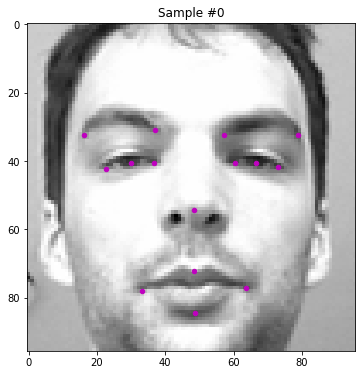

index: 1
image size: (1, 96, 96)
keypoint shape: (15, 2)


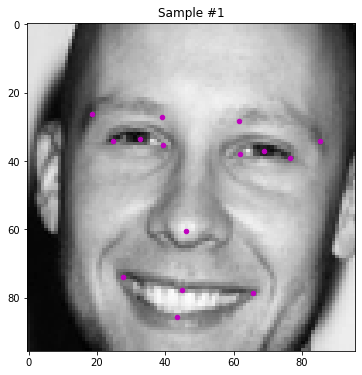

index: 2
image size: (1, 96, 96)
keypoint shape: (15, 2)


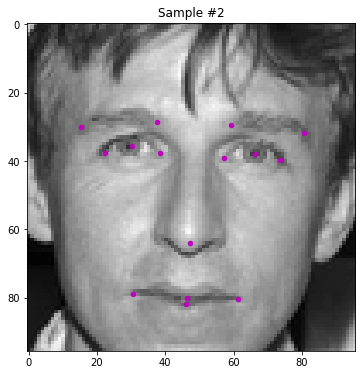

In [7]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image size: {}'.format(sample['image'].shape))
    print('keypoint shape: {}'.format(sample['keypoints'].shape))

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_all_keypoints(sample['image'][0], sample['keypoints'])


## Transforms

Neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create 2 transforms:

-  ``Normalize``: to convert grayscale values with a range of [0, 1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``ToTensor``: to convert numpy images to torch images.


We will use the default transforms from torchvision

Observe below how these transforms are generally applied to both the image and its keypoints.



In [8]:
import torch
from torchvision import transforms, utils
# tranforms

from exercise_code.transforms import Normalize, ToTensor

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. 

## Create the transformed dataset

Apply the transforms in order to normalized images and landmarks. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

#### Hint: you can also implement or use some other default PyTorch data augmenatiton methods to improve your scores! 

In [9]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='../datasets/landmark_data/training.csv',
                                             transform = data_transform)


In [10]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(1):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  1546
0 torch.Size([1, 96, 96]) torch.Size([15, 2])


## Data Iteration and Batching

Right now, we are iterating over this data using a ``for`` loop, but we are missing out on a lot of PyTorch's dataset capabilities, specifically the abilities to:

-  Batch the data
-  Shuffle the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features, and we'll see how this is used, when we load data in batches to train a neural network! Then we can define a DataLoader class from PyTorch with transformed dataset, with batch size 4, shuffle functionality and multithreading with 4 workers.

#### Note: num_workers > 0 might throw an error on machines without cuda. You might consider leaving num_workers=0 if you are working on CPU

---



In [11]:
from torch.utils.data import DataLoader
batch_size = 20
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


#### TODO: Define your model in the provided file `exercise_code/classifiers/keypoint_nn.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

In [25]:
from exercise_code.classifiers.keypoint_nn import KeypointModel
model = KeypointModel()
# print(model)

index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


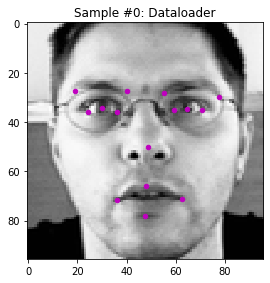

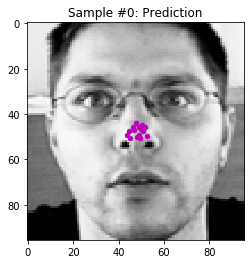

index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


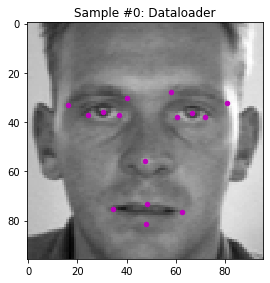

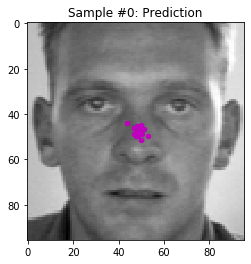

index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


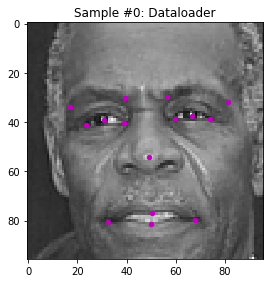

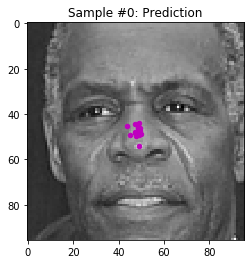

In [29]:
# Display a few output samples from our network
def show_sample_outputs(image, keypoints):    
    # define the size of images
    fig = plt.figure(figsize=(20,20))
     
    # Predict with model
    predicted_keypoints = model(image)[0]
    # Cast back to (x,y)-coordinates
    predicted_keypoints = predicted_keypoints.view(-1, 2).detach()

    # Undo data normalization
    image = torch.squeeze(image) * 255.
    keypoints = (keypoints.view(-1, 2) * 48) + 48
    predicted_keypoints = (predicted_keypoints * 48) + 48

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image shape: {}'.format(image.shape))
    print('gt keypoints shape: {}'.format(keypoints.shape))
    print('predict keypoints shape: {}'.format(predicted_keypoints.shape))
    
    # Print data loader image
    ax = plt.subplot(4, 1, 1)
    ax.set_title('Sample #{}: Dataloader'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, keypoints)

    # Print predicted image
    ax = plt.subplot(1, 1, 1)
    ax.set_title('Sample #{}: Prediction'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, predicted_keypoints)
    plt.show()
    
num_to_display = 3
for idx, sample in enumerate(train_loader):
    if idx == num_to_display:
        break
    show_sample_outputs(sample['image'][0:1], sample['keypoints'][0:1])

## Training your network
We define the sovler for you to use, basically it takes out the data from the DataLoader, and via PyTorch functions to run forward and backward pass. If you want define your own solver, it is also welcome, feel free to change to achieve your best scores)

In [ ]:
import torch.optim as optim
from torch import nn
from exercise_code.classifiers.keypoint_nn import KeypointModel

def train_net(n_epochs):

    # prepare the net for training
    model.train()
    running_loss = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            #print(key_pts[0], images[0])

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss += loss.item()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1,
                                                                   batch_i + 1,
                                                                   running_loss / (len(train_loader) * epoch + batch_i)))
            
            #return images, key_pts, output_pts

    print('Finished Training')

    
# Load model and run the solver
model = KeypointModel()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
# train_net(n_epochs=15)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), betas=([0.9, 0.999]), lr=0.001, weight_decay=1e-08)
train_net(n_epochs=40)

Epoch: 1, Batch: 10, Avg. Loss: 0.06927332675291432
Epoch: 1, Batch: 20, Avg. Loss: 0.04621692776287857
Epoch: 1, Batch: 30, Avg. Loss: 0.0367815216425164
Epoch: 1, Batch: 40, Avg. Loss: 0.030881525781483222
Epoch: 1, Batch: 50, Avg. Loss: 0.027360801033827722
Epoch: 1, Batch: 60, Avg. Loss: 0.025034056692305257
Epoch: 1, Batch: 70, Avg. Loss: 0.023114012675764767
Epoch: 2, Batch: 10, Avg. Loss: 0.020597753141760485
Epoch: 2, Batch: 20, Avg. Loss: 0.019469708295481412
Epoch: 2, Batch: 30, Avg. Loss: 0.018540082999861963
Epoch: 2, Batch: 40, Avg. Loss: 0.017741917234519098
Epoch: 2, Batch: 50, Avg. Loss: 0.017056721882293308
Epoch: 2, Batch: 60, Avg. Loss: 0.016568261256482263
Epoch: 2, Batch: 70, Avg. Loss: 0.01614421273765414
Epoch: 3, Batch: 10, Avg. Loss: 0.015452911301205555
Epoch: 3, Batch: 20, Avg. Loss: 0.015064540249960763
Epoch: 3, Batch: 30, Avg. Loss: 0.014692237557893669
Epoch: 3, Batch: 40, Avg. Loss: 0.014438584783615975
Epoch: 3, Batch: 50, Avg. Loss: 0.01419229003169187

Epoch: 23, Batch: 10, Avg. Loss: 0.005925859528985144
Epoch: 23, Batch: 20, Avg. Loss: 0.005907244246818061
Epoch: 23, Batch: 30, Avg. Loss: 0.0058918112006977755
Epoch: 23, Batch: 40, Avg. Loss: 0.005874348053989927
Epoch: 23, Batch: 50, Avg. Loss: 0.005858203178145013
Epoch: 23, Batch: 60, Avg. Loss: 0.005840224486080484
Epoch: 23, Batch: 70, Avg. Loss: 0.0058222896806864426
Epoch: 24, Batch: 10, Avg. Loss: 0.005789936779849996
Epoch: 24, Batch: 20, Avg. Loss: 0.005772864864702489
Epoch: 24, Batch: 30, Avg. Loss: 0.005755232990496126
Epoch: 24, Batch: 40, Avg. Loss: 0.005738687013955233
Epoch: 24, Batch: 50, Avg. Loss: 0.005723517539830625
Epoch: 24, Batch: 60, Avg. Loss: 0.0057069473502593575
Epoch: 24, Batch: 70, Avg. Loss: 0.005691117819641595
Epoch: 25, Batch: 10, Avg. Loss: 0.005661243771436559
Epoch: 25, Batch: 20, Avg. Loss: 0.005646752537029196
Epoch: 25, Batch: 30, Avg. Loss: 0.0056320149171632024
Epoch: 25, Batch: 40, Avg. Loss: 0.005617899372640067
Epoch: 25, Batch: 50, Av

## Display the trained outputs

index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


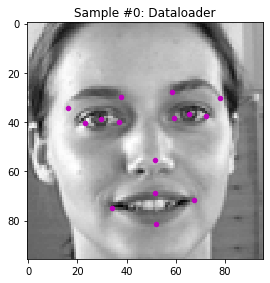

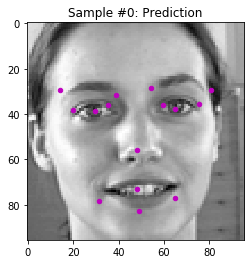

index: 1
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


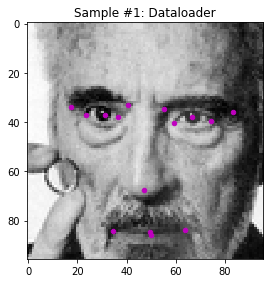

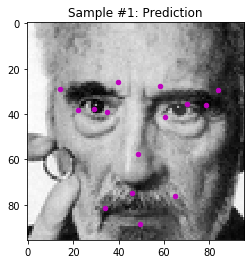

index: 2
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


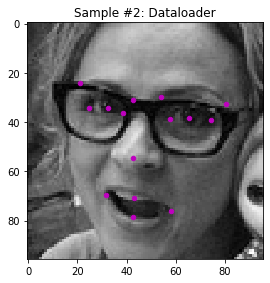

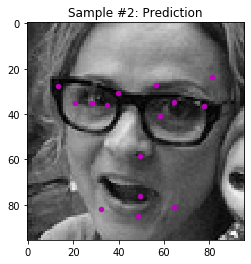

In [31]:
#show_sample_outputs(images[0:1], key_pts[0])

num_to_display = 3 
for i in range(num_to_display):
    sample = next(iter(train_loader))
    show_sample_outputs(sample['image'][0:1], sample['keypoints'][0])

## Validation on model
For our experiments, we use mean squared error (MSE) between the ground truth keypoint coordinate vector and the predicted keypoint coordinate vector. Given the ground truth vector and predict vector, MSE loss is defined as the average of the square of all of the error. 

#### Notice: the metric in this validation section is the same metric used in test evaluation.  You have to achieve more than 100 to get bonus.

In [36]:
def VAL_net():
    # prepare the net for training
    model.eval()
    running_loss = 0.0

    # train on batches of data, assumes you already have train_loader
    for batch_i, data in enumerate(val_loader):
        # get the input images and their corresponding labels
        images = data['image']
        key_pts = data['keypoints']

        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)

        # forward pass to get outputs
        output_pts = model(images)

        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)

        # print loss statistics
        # to convert loss into a scalar and add it to the running_loss, use .item()
        running_loss += loss.item()
    # metric is 1 / (2 * MSE_loss)
    metric = 1.0 / (2 * (running_loss/len(val_loader)))
    print("Metric on VAL data: {}".format(metric))
    print('Finished Validation')
    
# create the validation dataset

VAL_dataset = FacialKeypointsDataset(csv_file='../datasets/landmark_data/val.csv',
                                     transform=data_transform)
val_loader = DataLoader(VAL_dataset, 
                        batch_size=20,
                        shuffle=True, 
                        num_workers=4,
                        drop_last=True,
                       )
criterion = nn.MSELoss()
VAL_net()

Metric on VAL data: 55.93169171306211
Finished Validation


## Save the Model

When you are satisfied with your training, save the model for submission.

In [ ]:
model.save("models/keypoints_nn.model")